## Complex Laplacian null connectivity comparison and statistics

In [1]:
%%capture --no-display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from scipy.spatial import distance

# spectrome imports
from spectrome.brain import Brain
from spectrome.utils import functions, path
from spectrome.forward import eigenmode, get_complex_laplacian, runforward

#### House keeping and creating BRAIN object from spectome:

In [25]:
# hcp template connectome directory
hcp_dir = "../../data"

# Define frequency range of interest
fmin = 2  # 2Hz - 45Hz signal range, filter for this with hbp
fmax = 45
fvec = np.linspace(fmin, fmax, 40)
f2w = np.abs(fvec - 2).argmin()  # 8th index = alpha ~10hz
w = 2 * np.pi * fvec[f2w]

#expanding low frequencies
fvlow = np.linspace(0.1,5,40)

In [41]:
# spectrome's BRAIN object
HCP_brain = Brain.Brain()
HCP_brain.add_connectome(hcp_dir)
HCP_brain.reorder_connectome(HCP_brain.connectome, HCP_brain.distance_matrix)
HCP_brain.bi_symmetric_c()
HCP_brain.reduce_extreme_dir()
HCP_brain.add_laplacian_eigenmodes(w=w, alpha=1, speed=5, num_ev=86)
HCP_brain.norm_eigenmodes.shape

(86, 86)

### Load canonical networks (Yeo):

In [42]:
# Load Pablo's Yeo 2017 canonical network maps
com_dk = np.load(
    "../../data/com_dk.npy",
    allow_pickle = True
).item()
DK_df_normalized = pd.read_csv(
    "../../data/DK_dictionary_normalized.csv"
).set_index("Unnamed: 0")
coords = np.array([com_dk[region] for region in DK_df_normalized.columns])
# Create FC network jupyter widget for visiualization
fc_names = [
    "Visual",
    "Limbic",
    "Default",
    "Somatomotor",
    "Frontoparietal",
    "Ventral_Attention",
    "Dorsal_Attention",
]

#### binarize eigenmodes and threshold according to canonical networks:

We need to threshold so that the amount of non-zero elements in the eigenmodes are similar to the support of the canonical networks they are being compared to. Plot the distribution of these canonical network's region-wise weights first.

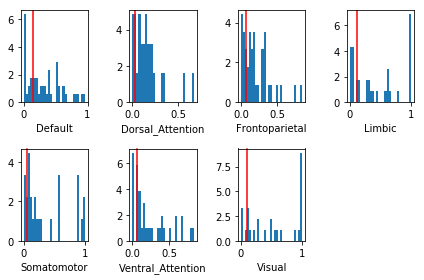

In [43]:
p = 1
for names in DK_df_normalized.index:
    y = np.nan_to_num(DK_df_normalized.loc[names].values)
    u = np.mean(y)
    s = np.std(y)
    plt.subplot(2, 4, p)
    plt.hist(y[np.nonzero(y)], 30, density=True)
    plt.xlabel(names)
    plt.axvline(u - s * 0.2, color="r")
    p += 1

plt.tight_layout()

In [44]:
# binarize according to threshold:
# threshold, ub, lb = 0.2, 1, 0, no longer using the 0.2, we will use threshold = mean-0.1*std
ub, lb = 1, 0

DKfc_binarized = pd.DataFrame(
    [], index=DK_df_normalized.index, columns=DK_df_normalized.columns
)
for name in DK_df_normalized.index:
    u = np.mean(np.nan_to_num(DK_df_normalized.loc[name].values))
    s = np.std(np.nan_to_num(DK_df_normalized.loc[name].values))
    threshold = u - s * 0.1
    DKfc_binarized.loc[name] = np.where(
        DK_df_normalized.loc[name].values > threshold, ub, lb
    )
    print(
        "Number of non-zero elements in {} network is {}".format(
            name, np.count_nonzero(DKfc_binarized.loc[name].values)
        )
    )

DKfc_binarized

Number of non-zero elements in Default network is 32
Number of non-zero elements in Dorsal_Attention network is 22
Number of non-zero elements in Frontoparietal network is 29
Number of non-zero elements in Limbic network is 22
Number of non-zero elements in Somatomotor network is 22
Number of non-zero elements in Ventral_Attention network is 24
Number of non-zero elements in Visual network is 20


,ctx-lh-bankssts,ctx-lh-caudalanteriorcingulate,ctx-lh-caudalmiddlefrontal,ctx-lh-cuneus,ctx-lh-entorhinal,ctx-lh-fusiform,ctx-lh-inferiorparietal,ctx-lh-inferiortemporal,ctx-lh-isthmuscingulate,ctx-lh-lateraloccipital,...,Left-VentralDC,Right-Cerebellum-Cortex,Right-Thalamus-Proper,Right-Caudate,Right-Putamen,Right-Pallidum,Right-Hippocampus,Right-Amygdala,Right-Accumbens-area,Right-VentralDC
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
Default,1,0,1,0,0,0,1,0,1,0,...,0,0,0,0,0,0,1,0,0,0
Dorsal_Attention,0,0,1,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Frontoparietal,0,1,1,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Limbic,0,0,0,0,1,1,0,1,0,0,...,0,0,0,0,0,0,1,1,1,0
Somatomotor,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Ventral_Attention,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
Visual,0,0,0,1,0,1,0,0,0,1,...,0,1,0,0,0,0,1,0,0,0


### Binarize eigenmodes:

We want to binarize the eigenmodes so that there are about 24.0 non-zero elements.


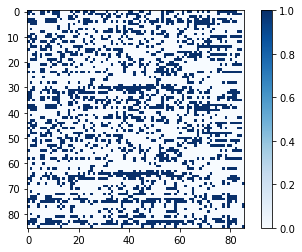

In [45]:
# firstly, what is the average number of non-zero elements in the canonical networks?
print(
    "We want to binarize the eigenmodes so that there are about {} non-zero elements.".format(
        np.round(np.mean(np.count_nonzero(DKfc_binarized.values, axis=1)))
    )
)

thresh_vec = np.linspace(0.1, 1, 10)
binary_count = np.zeros(thresh_vec.shape)
for i in np.arange(0, len(thresh_vec)):
    binary_mat = np.where(HCP_brain.norm_eigenmodes > thresh_vec[i], ub, lb)
    binary_count[i] = np.around(np.mean(np.count_nonzero(binary_mat, axis=1)))

binary_count  # looks like we pick the entry that give us 26, which is i = 5, 6th entry

HCP_brain.binary_eigenmodes = np.where(
    HCP_brain.norm_eigenmodes > thresh_vec[5], ub, lb
)
plt.imshow(HCP_brain.binary_eigenmodes, cmap=plt.cm.Blues)
plt.colorbar()

### Create distribution of similarity metrics from HCP:

In [46]:
# DICE dissimilarity metric:
hcp_dice = eigenmode.get_dice_df(HCP_brain.binary_eigenmodes, DKfc_binarized)

# convert hcp_dice to distributions:

In [47]:
viz_hist = hcp_dice['Default'].values
viz_hist = np.round(viz_hist.astype(np.double),2)

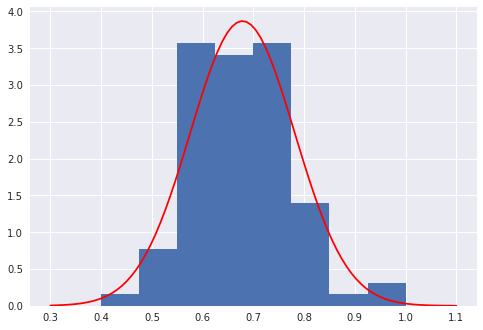

In [48]:
%matplotlib inline

from scipy import stats

with plt.style.context('seaborn'):
    plt.hist(viz_hist, bins = 8, density = True, histtype = 'bar')
    xvals = plt.xticks()[0]
    xmin, xmax = min(xvals), max(xvals)
    xbins = np.linspace(xmin, xmax, len(viz_hist))
    mu, sigma = stats.norm.fit(viz_hist)
    gaussian_pdf = stats.norm.pdf(xbins, mu, sigma)
    plt.plot(xbins, gaussian_pdf,'r', label = 'Gaussian Fit')

#### Plot all canonical network's DICE distributions:

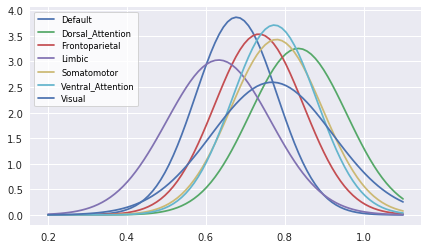

In [56]:
plt.figure('All DICE Distributions', figsize = [7, 4])
xmin, xmax = 0.2, 1.1
for columns in hcp_dice:
    plot_dice = np.round(hcp_dice[columns].values.astype(np.double),3)
    xbins = np.linspace(xmin, xmax, len(plot_dice))
    mu, sigma = stats.norm.fit(plot_dice)
    gaussian_pdf = stats.norm.pdf(xbins,mu,sigma)
    with plt.style.context('seaborn'):
        #plt.subplot(1,7,p)
        plt.plot(xbins, gaussian_pdf, label = columns)
plt.legend(loc = 'upper left', fontsize = 'small')

### Use gradient descent to find best parameters per network:

define laplacian function to be optimized:

In [68]:
def laplacian_dice(x, Brain, FC_networks, network_name):
    # Define frequency range of interest
    fmin = 0
    fmax = 45
    fvec = np.linspace(fmin, fmax, 50)
    f2w = np.abs(fvec - x[0]).argmin()  # 8th index = alpha ~10hz
    w = 2 * np.pi * fvec[f2w]
    # Laplacian, Brain already prep-ed with connectomes outside of function:
    Brain.add_laplacian_eigenmodes(w=w, alpha = x[1], speed = x[2], num_ev = 86)
    # Dice:
    HCP_brain.binary_eigenmodes = np.where(HCP_brain.norm_eigenmodes > 0.6, 1, 0)
    hcp_dice = eigenmode.get_dice_df(HCP_brain.binary_eigenmodes, FC_networks)
    # Compute mean Dice for chosen network:
    ntw_dice = np.round(hcp_dice[network_name].values.astype(np.double),3)
    mean_dice = np.mean(ntw_dice)
    return mean_dice

scipy `basinhopping` algorithm for minimization with Limbic system first：

In [ ]:
from scipy.optimize import basinhopping
HCP_brain = Brain.Brain()
HCP_brain.add_connectome(hcp_dir)
HCP_brain.reorder_connectome(HCP_brain.connectome, HCP_brain.distance_matrix)
HCP_brain.bi_symmetric_c()
HCP_brain.reduce_extreme_dir()
bnds = ((0,45),(0,5),(0.5,30))

#opt_res = fmin_l_bfgs_b(laplacian_dice, (2, 0.5, 10), args = (HCP_brain, DKfc_binarized, 'Limbic'), approx_grad = True, bounds = bnds)
opt_res = basinhopping(laplacian_dice, x0 = (2,0.5,10), minimizer_kwargs = {"args":(HCP_brain, DKfc_binarized, 'Limbic')}, niter=250,  disp=True)
opt_res

basinhopping step 0: f 0.634767
basinhopping step 1: f 0.63443 trial_f 0.63443 accepted 1  lowest_f 0.63443
found new global minimum on step 1 with function value 0.63443
basinhopping step 2: f 0.634593 trial_f 0.634593 accepted 1  lowest_f 0.63443
basinhopping step 3: f 0.632116 trial_f 0.632116 accepted 1  lowest_f 0.632116
found new global minimum on step 3 with function value 0.632116
basinhopping step 4: f 0.631419 trial_f 0.631419 accepted 1  lowest_f 0.631419
found new global minimum on step 4 with function value 0.631419
basinhopping step 5: f 0.634477 trial_f 0.634477 accepted 1  lowest_f 0.631419
basinhopping step 6: f 0.63186 trial_f 0.63186 accepted 1  lowest_f 0.631419
basinhopping step 7: f 0.635081 trial_f 0.635081 accepted 1  lowest_f 0.631419
basinhopping step 8: f 0.635128 trial_f 0.635128 accepted 1  lowest_f 0.631419
basinhopping step 9: f 0.634802 trial_f 0.634802 accepted 1  lowest_f 0.631419
basinhopping step 10: f 0.63443 trial_f 0.63443 accepted 1  lowest_f 0.6

In [ ]:
opt_res